<h1 class=bold> Portugesse Banking - Exploratory Data Analysis </h1>

`#### Setting the environment ####`

In [ ]:
!pip install janitor
!pip install sklearn
!pip install pandas
!pip install pyjanitor

In [1]:
# Buiilt-ins
import pathlib
import sys
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

from scipy.stats import zscore
import pandas as pd
import numpy as np
import janitor  # pandas DataFrame injection using pandas-flavor library

from sklearn.decomposition import PCA

# Allowing imports from local package
root_dir = pathlib.Path.cwd().parent
sys.path.append(str(root_dir))

from portuguesse_banking.visualizations import (build_dashboard_for_numerical_features,
                                                build_dashboard_for_categorical_features)

`#### Data Preview ####`

In [2]:
data = (pd.read_csv(filepath_or_buffer=root_dir.joinpath('data/bank_data_prediction_task.csv'),
                   index_col=0,
                   low_memory=False)
        .clean_names())  # changing "." to "_" and doing lower()

data.shape

(41188, 22)

In [3]:
data.dropna().sample(3).transpose().assign(dtype=data.dtypes)

13639            4168            1854    dtype
age                            53              46              33    int64
job                        admin.       housemaid       housemaid   object
marital                   married         married         married   object
education                basic.9y        basic.4y        basic.4y   object
default                        no         unknown              no   object
housing                       yes              no         unknown   object
loan                          yes             yes         unknown   object
contact                  cellular       telephone       telephone   object
month                         may             jun             may   object
day_of_week                   wed             tue             tue   object
duration                    674.0           166.0           129.0  float64
campaign                      1.0             1.0             8.0  float64
pdays                         999             999             999    int64
previous                        0               0               0    int64
poutcome              nonexistent     nonexistent     nonexistent   object
emp_var_rate                 -1.8             1.4             1.1  float64
cons_price_idx             92.893          94.465          93.994  float64
cons_conf_idx               -46.2           -41.8           -36.4  float64
euribor3m                   1.281           4.961           4.856  float64
nr_employed                5099.1          5228.1          5191.0  float64
y                             yes              no              no   object
test_control_flag  campaign group  campaign group  campaign group   object

In [4]:
data['y'] = data['y'].map({'yes':True, 'no':False})

In [5]:
data['y']

1        False
2        False
3         True
4        False
5        False
         ...  
41184    False
41185    False
41186    False
41187     True
41188    False
Name: y, Length: 41188, dtype: bool

`#### Numerical features ####`

In [6]:
numerical_features = data.select_dtypes(['number'])
data.describe().transpose().assign(dtype=data.dtypes)

count         mean         std       min       25%  \
age             41188.0    40.024060   10.421250    17.000    32.000   
duration        16476.0   259.660172  260.660561     0.000   103.000   
campaign        16476.0     2.546856    2.699664     1.000     1.000   
pdays           41188.0   962.475454  186.910907     0.000   999.000   
previous        41188.0     0.172963    0.494901     0.000     0.000   
emp_var_rate    41188.0     0.081886    1.570960    -3.400    -1.800   
cons_price_idx  40938.0    93.575950    0.578889    92.201    93.075   
cons_conf_idx   41188.0   -40.502600    4.628198   -50.800   -42.700   
euribor3m       41188.0     3.621291    1.734447     0.634     1.344   
nr_employed     41188.0  5167.035911   72.251528  4963.600  5099.100   

                     50%       75%       max    dtype  
age               38.000    47.000    98.000    int64  
duration         180.000   321.000  4918.000  float64  
campaign           2.000     3.000    43.000  float64  
pdays            999.000   999.000   999.000    int64  
previous           0.000     0.000     7.000    int64  
emp_var_rate       1.100     1.400     1.400  float64  
cons_price_idx    93.749    93.994    94.767  float64  
cons_conf_idx    -41.800   -36.400   -26.900  float64  
euribor3m          4.857     4.961     5.045  float64  
nr_employed     5191.000  5228.100  5228.100  float64

In [7]:
(data[data['test_control_flag'] == 'campaign group'].duration == 0).sum()

2

__Numerical features - Findings__:

- duration and campaign don't have more than half observations. Those missing values might be connected with the control group.

- few features have float type instead of int (because of NaNs)

- pdays, and previous variable is heavily skewed, additionally pdays variable has been imputed with value 999 which can be problematic both during eda, and modeling -> we will bin pdays, and previous feature and treat it as a categorical feature from now on.

- there might be a few outliers in the data (duration, campaign)

In [8]:
data['previous'] = pd.cut(data['previous'],
                          bins= [-1, 0, 1, 10],
                          labels=["not_called", 'called_one_time', 'called_more_then_one_time'])

# grabbing intervals using quantile cut without imputed 999 values
pday_bin_intervals = list(
                          map(lambda interval: interval.left,
                              pd.qcut(data.loc[data['pdays'] < 999, 'pdays'], 4).unique())
) + [998, 1000]  # To grab value 999 in the last bin

data['pdays'] = pd.cut(data['pdays'],
                       bins=sorted(pday_bin_intervals),
                       labels=['less then 3', '3-6', '6-7', 'more then 7', 'no previous contact'])

numerical_features = data.select_dtypes('number')  # excluding pdays and previous

In [9]:
pday_bin_intervals

[3.0, -0.001, 7.0, 6.0, 998, 1000]

`Categorical variables` 

In [10]:
categorical_variables = data.select_dtypes(['object', 'category'])

for feature in categorical_variables:
    print(f'Feature - {feature.upper()}', end=f"\n{'*'*50}\n")
    print(data[feature].value_counts(), end="\n\n")

Feature - JOB
**************************************************
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

Feature - MARITAL
**************************************************
married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

Feature - EDUCATION
**************************************************
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

Feature - DEFAULT
**************************************************
no         32588
unknown     8597
yes            3
Name: defa

__Categorical features - Findings__:
 - there are nulls in few categorical features, described as 'unknown'. We will decide what to do with those during modeling phase
 
 - Campaign calls occur mostly during the may-august period
 
 - There were no calls during the weekend
 
 - Our target feature is slightly imbalanced with ratio of ~1:7 we might want to tackle this problem during modeling
 
 - Our target value should not be a categorical type, we need to change it.

`#### Missing Values ####`

In [11]:
null_series = data.isnull().sum()
null_series = null_series[null_series > 0]
pd.DataFrame(data={'n_nans': null_series,
                   'perc_nans': round(null_series / data.shape[0], 2)}) 

n_nans  perc_nans
contact          24712       0.60
month            24712       0.60
day_of_week      24712       0.60
duration         24712       0.60
campaign         24712       0.60
cons_price_idx     250       0.01

__Missing values - Findings__:
 - all observations in the control group don't have information about the contact. We shouldn't use this information during the modeling phase - it cannot be a predictor of who should be called. We might analyze it to find useful information for telemarketers on how to proceed with every call. Information about an optimal number of contact, the best time for it, and the duration of the calls will surely be useful.

`### Outliers ###`

In [12]:
for feature in numerical_features.columns:
    print(feature, (zscore(abs(data.dropna()[feature])) > 3).sum())

age 157
duration 334
campaign 324
emp_var_rate 421
cons_price_idx 0
cons_conf_idx 0
euribor3m 0
nr_employed 0


__Outliers - Findings__:
- Outliers will probably disturb our further EDA, so we will exclude them at this stage. During the modeling phase, we might want to check different strategies for dealing with them.


In [13]:
def drop_outliers_and_nans(data, feature, threshold=3):
    mask = (zscore(abs(data.dropna()[feature])) < 3)
    return data.dropna()[mask]

***

### Visualizations of feature distribution and target dependency

There is a big difference between the control group and campaign group regarding information about the impact of telemarketers' calls. Considering our problem, which is who should be called in the first place, we should focus mainly on the campaign group, because the control group contains only calls that happen independently from the campaign. In my opinion, we should try to train the predictive model on the campaign group and then apply it to the whole population of potential clients (with the corresponding newly established control group). 

Therefore, we will check only records from the campaign group from now on.

In [20]:
data_to_plot = data[data['test_control_flag'] == 'campaign group']

def plot_generator():
    for feature in numerical_features.columns:
        build_dashboard_for_numerical_features(
            data=drop_outliers_and_nans(data_to_plot.copy(), feature),
            feature=feature)
        yield

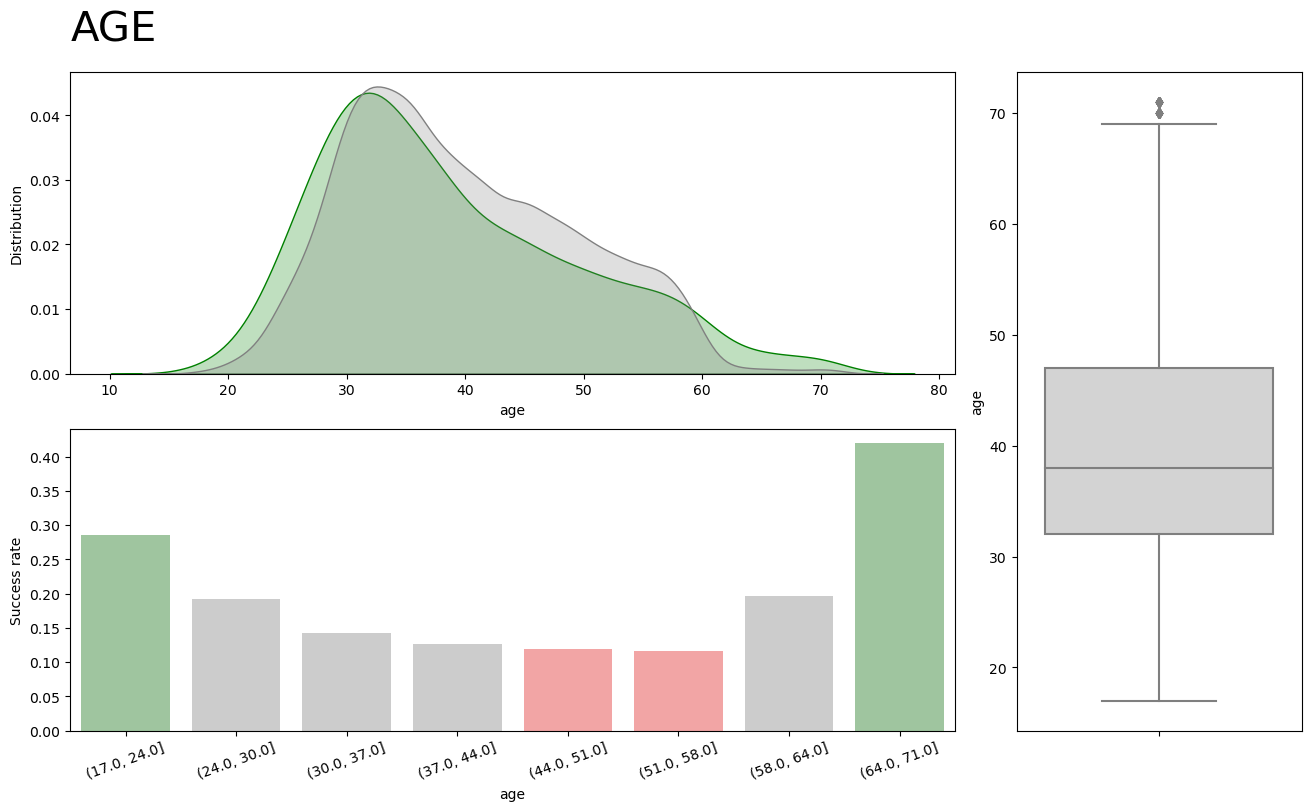

In [21]:
plot_gen = plot_generator()
next(plot_gen)

__Age - Findings:__

- there is an observable higher success rate on people with age > 64 and people younger than 27 years old
- even though people age 25 - 40 has a low success rate, they are the most numerous group in the dataset
- distribution is slightly skewed - it might be a good idea to transform it during modeling using Box-cox transformation to obtain Gaussian distribution on this feature.

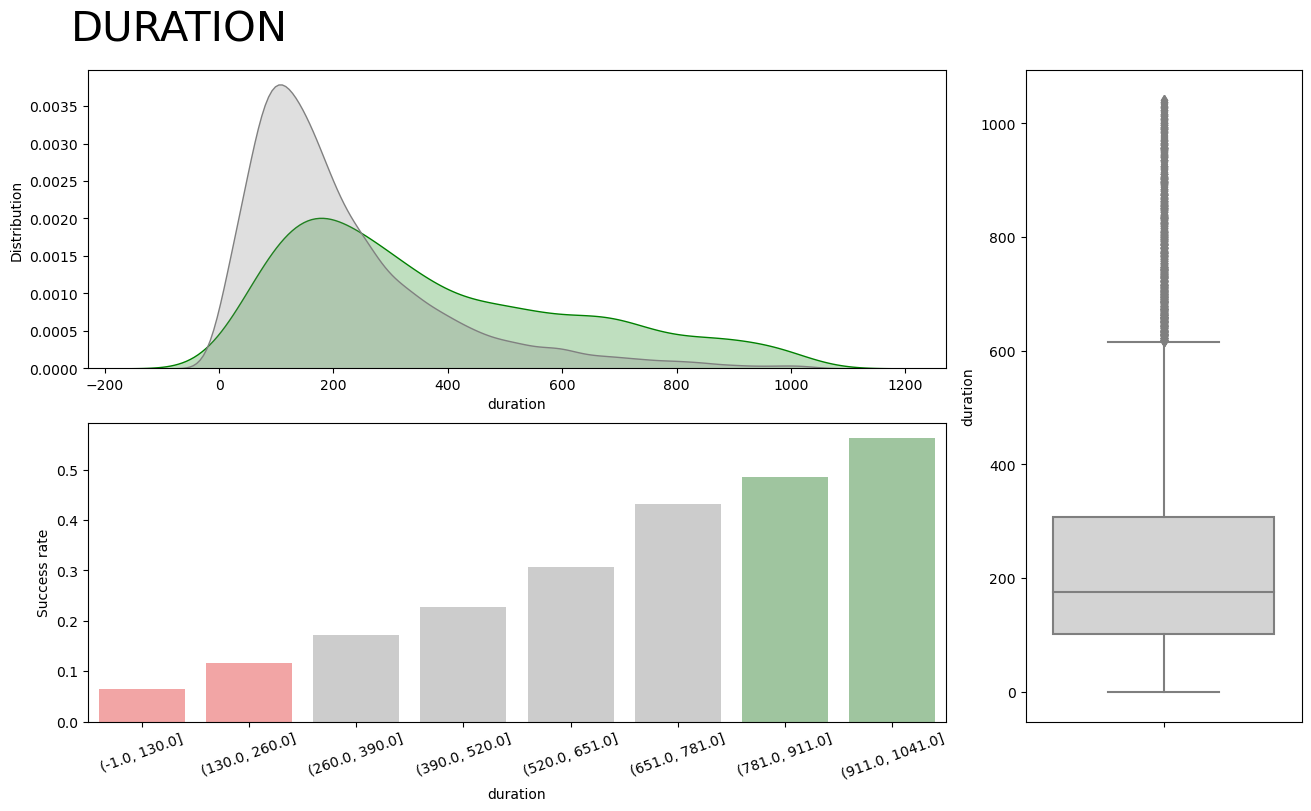

In [22]:
next(plot_gen)

__Duration - Findings:__

- The longer the call, the higher the success rate. This might not be an explicit causality effect, cause it might be connected with clients that are asking additional questions before agreeing to the offer, which simply takes additional time to process
- Most calls last less than 5 minutes.
- Duration is not available in most of the dataset, and for obvious reasons, we should not use it in the modeling phase. Nevertheless, it has some interesting insight into the telemarketer strategy.

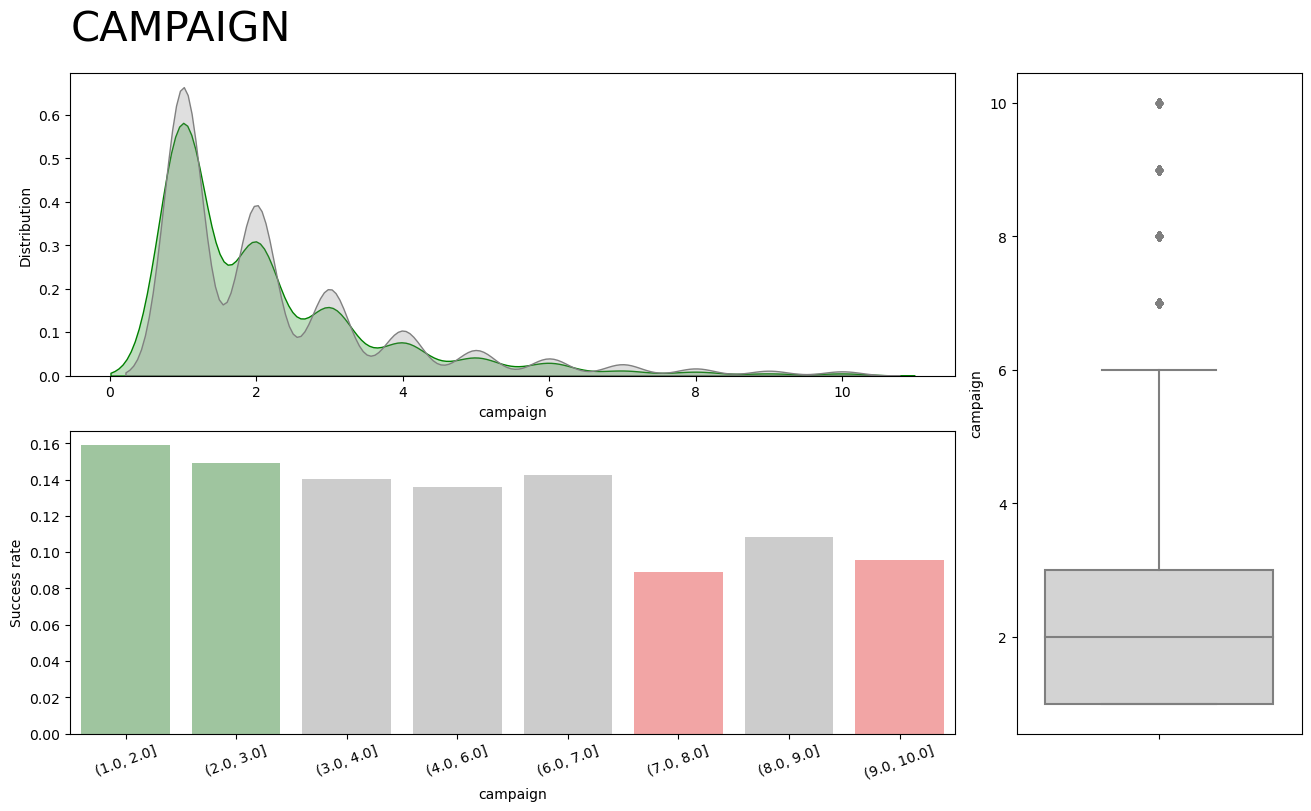

In [23]:
next(plot_gen)

__Campaign - Findings:__

- Small drop of success rate on values higher than 7.
- Most people were contacted 1-2 times during the campaign
- Distribution is highly skewed. It might be a good idea to transform it somehow

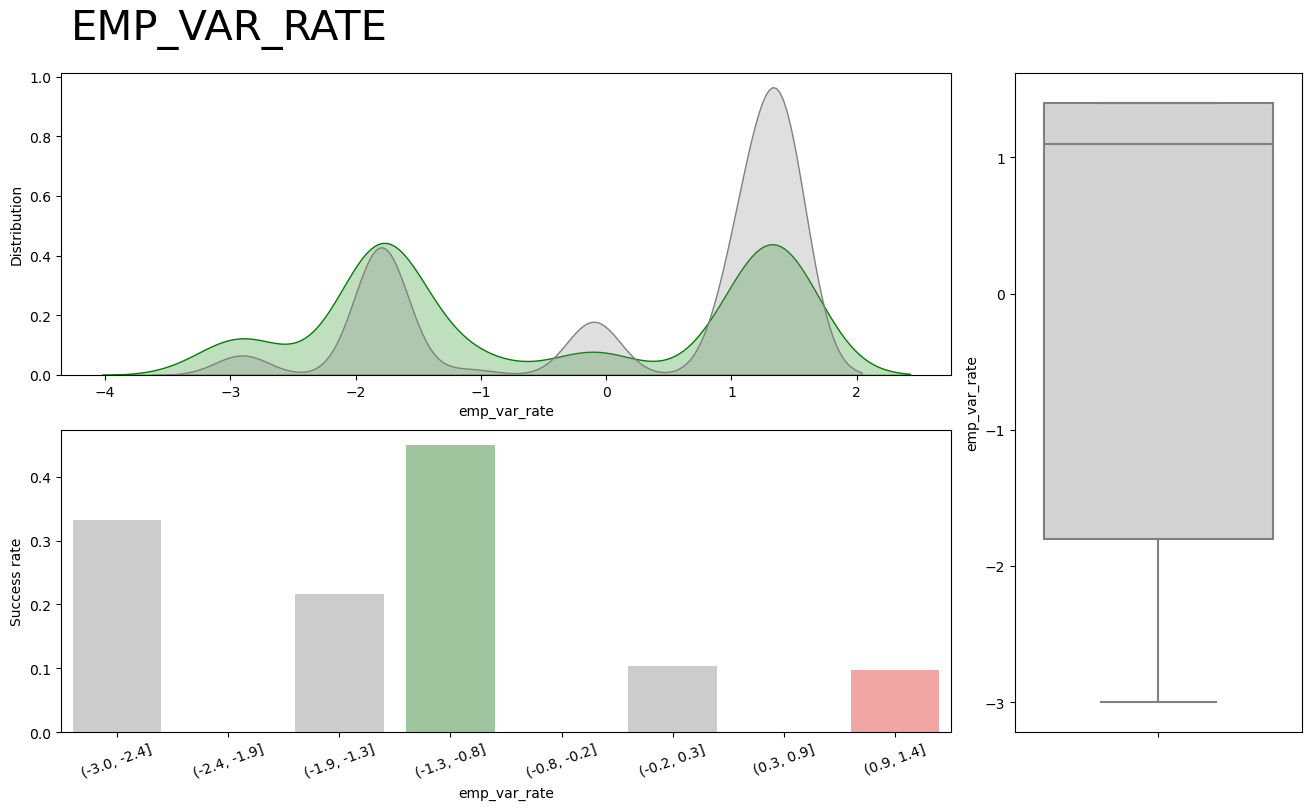

In [24]:
next(plot_gen)

<AxesSubplot:ylabel='Frequency'>

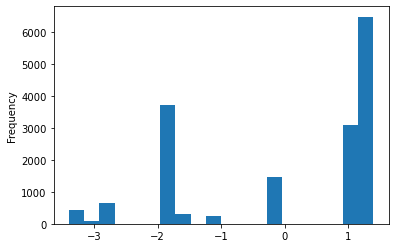

In [29]:
# Additional plot to gain more insight to the actual distribution
data_to_plot['emp_var_rate'].plot(kind='hist', bins=20)

__emp var rate - Findings:__

- bimodal distribution with local maxima around -1.8 and 1.4.
- it looks like a nice predictor for our target variable because of the high variance of success rate between the bins.

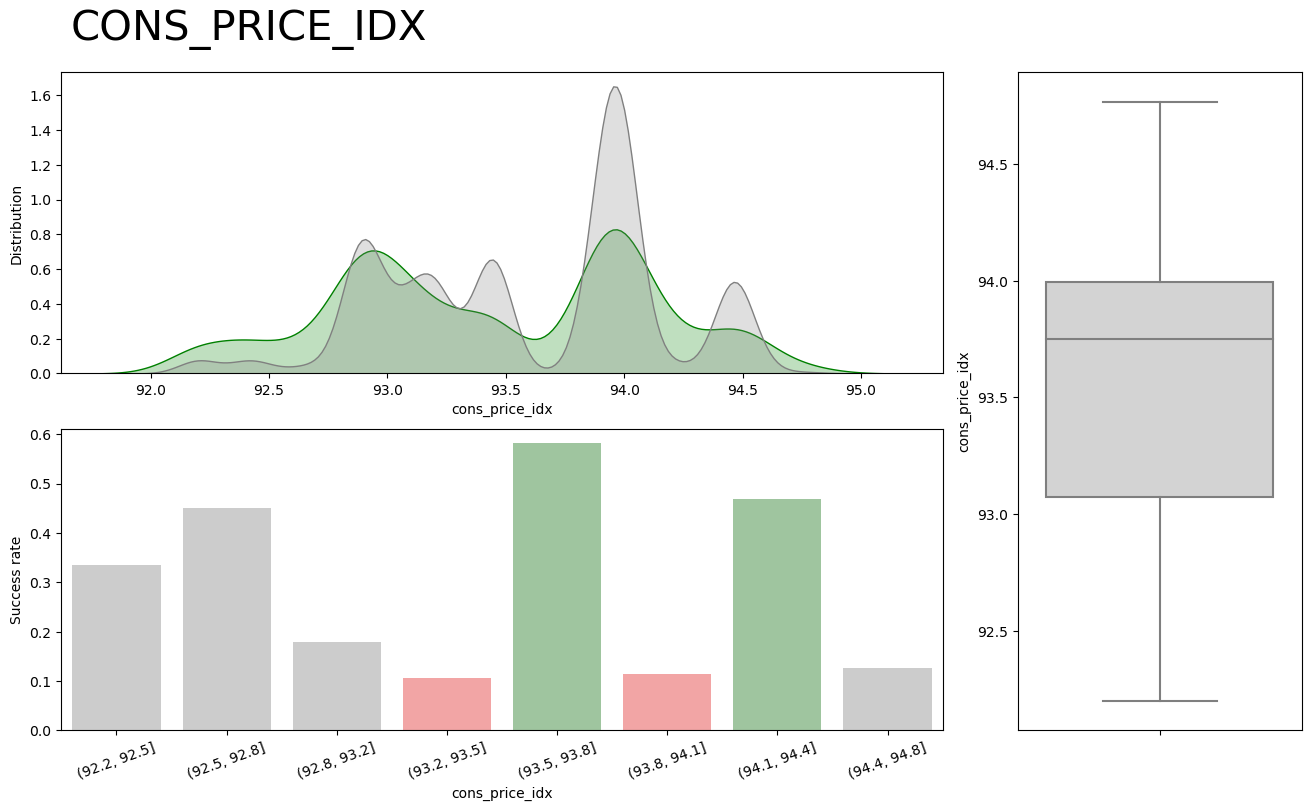

In [30]:
next(plot_gen)

<AxesSubplot:ylabel='Frequency'>

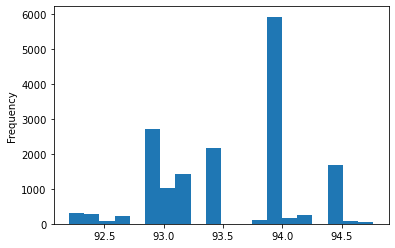

In [39]:
# Additional plot to gain more insight to the actual distribution
data_to_plot['cons_price_idx'].plot(kind='hist', bins=20)

__cons price idx - Findings:__

- it looks like a nice predictor for our target variable. Success rate variance is very high between the bins
- multimodal distribution

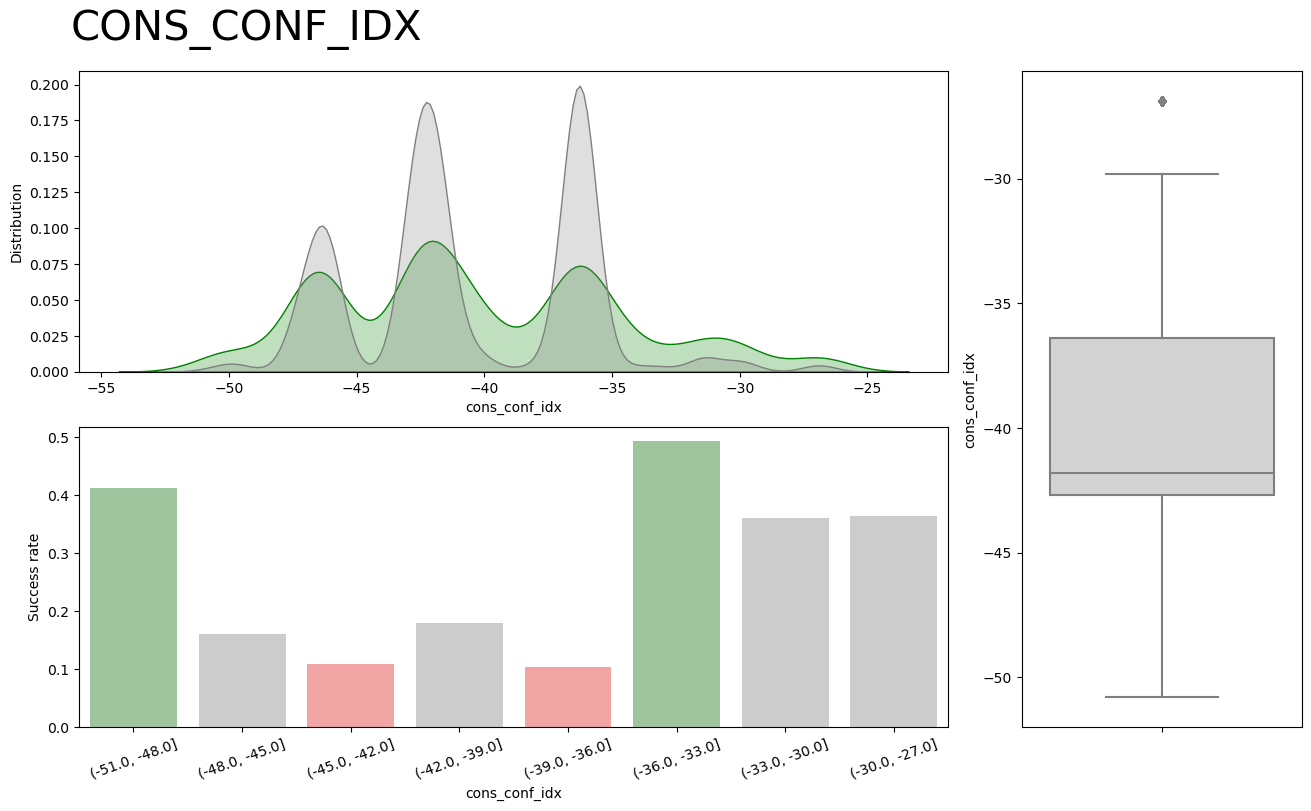

In [40]:
next(plot_gen)

<AxesSubplot:ylabel='Frequency'>

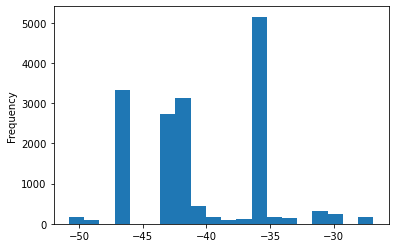

In [41]:
# Additional plot to gain more insight to the actual distribution
data_to_plot['cons_conf_idx'].plot(kind='hist', bins=20)

__Cons Conf Idx - Findings:__

- multimodal distribution with local maxima around -47, -43, -36
- high variance of success rate between the bins

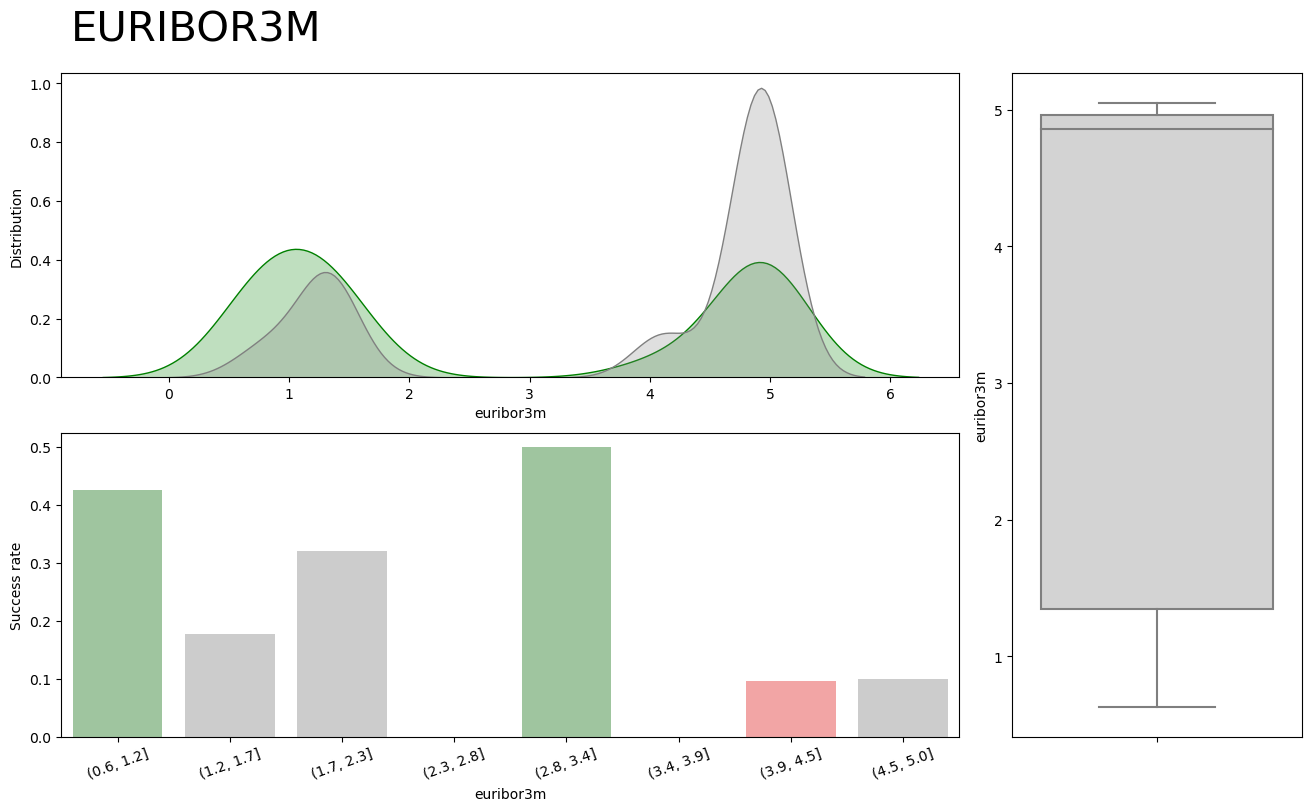

In [42]:
next(plot_gen)

__Euribor3M - Findings:__

- Bimodal distribution with local maximas around values 1 and 5
- Looks like a realy good predictor for our target variable. 
- Very high success rate at lower values.

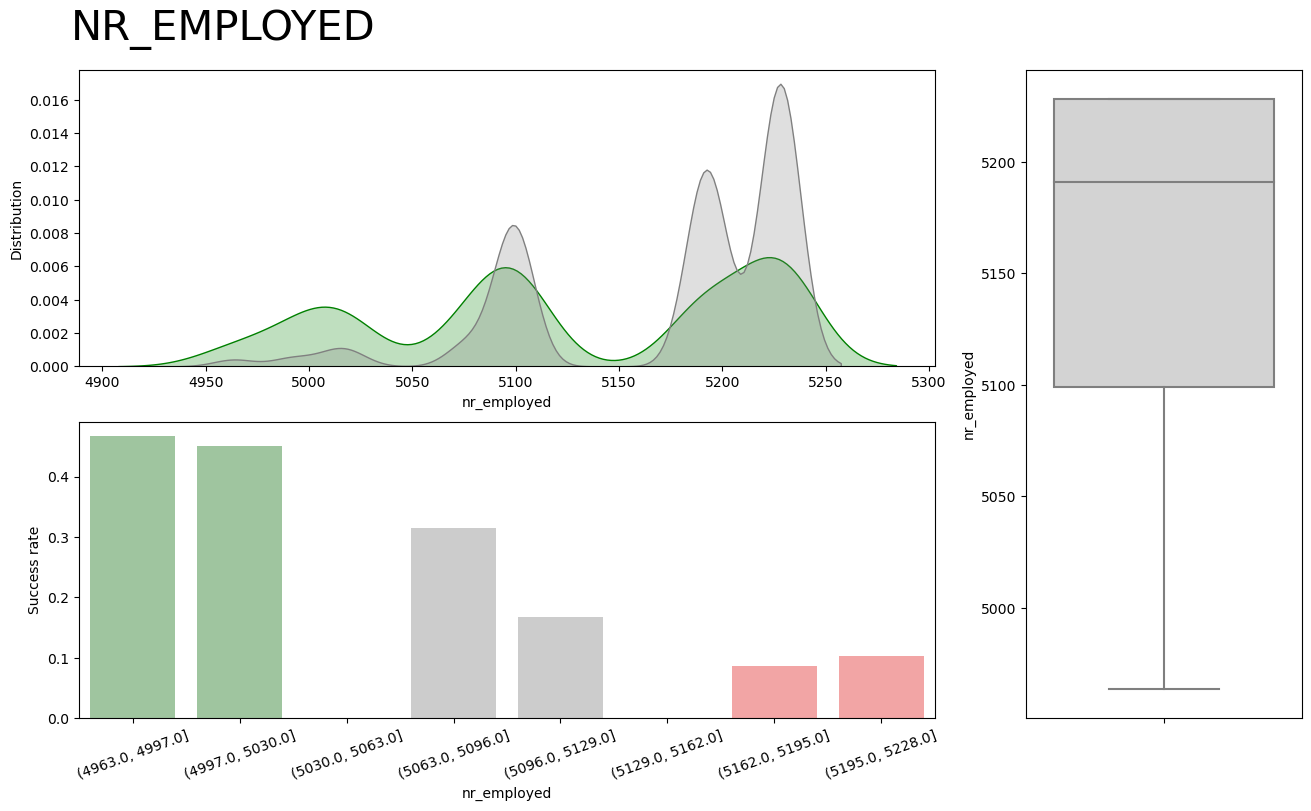

In [43]:
next(plot_gen)

__Nr Employed - Findings:__

- multimodal distribution with local maximals around 5100 and 5225
- very high success rates at lower levels

In [57]:
def categorical_plot_generator(data):
    for feature in data.select_dtypes(['object', 'category']).columns:
        build_dashboard_for_categorical_features(data_to_plot, feature)  
        yield

In [58]:
gen = categorical_plot_generator(data)

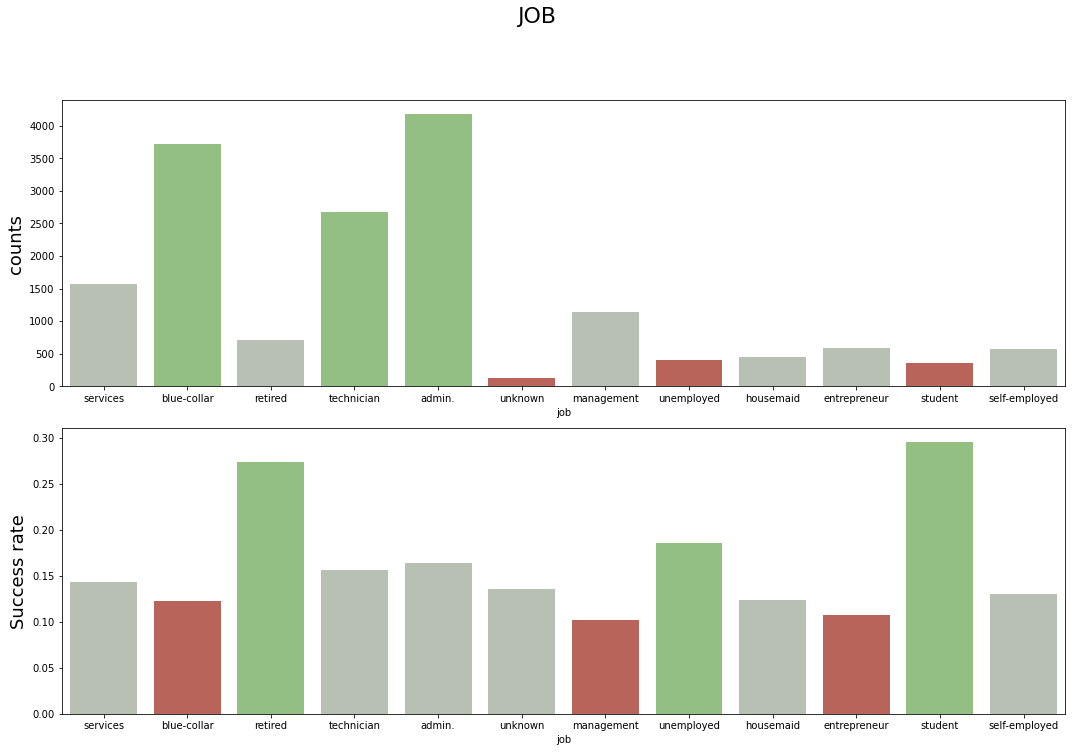

In [59]:
next(gen)

__Job - Findings:__

- Students and retired people have the highest success rate equals 25-30%
- the most numerous groups are blue-collars and admin.
- rest job title success rate is very similar and varies between 10-15%

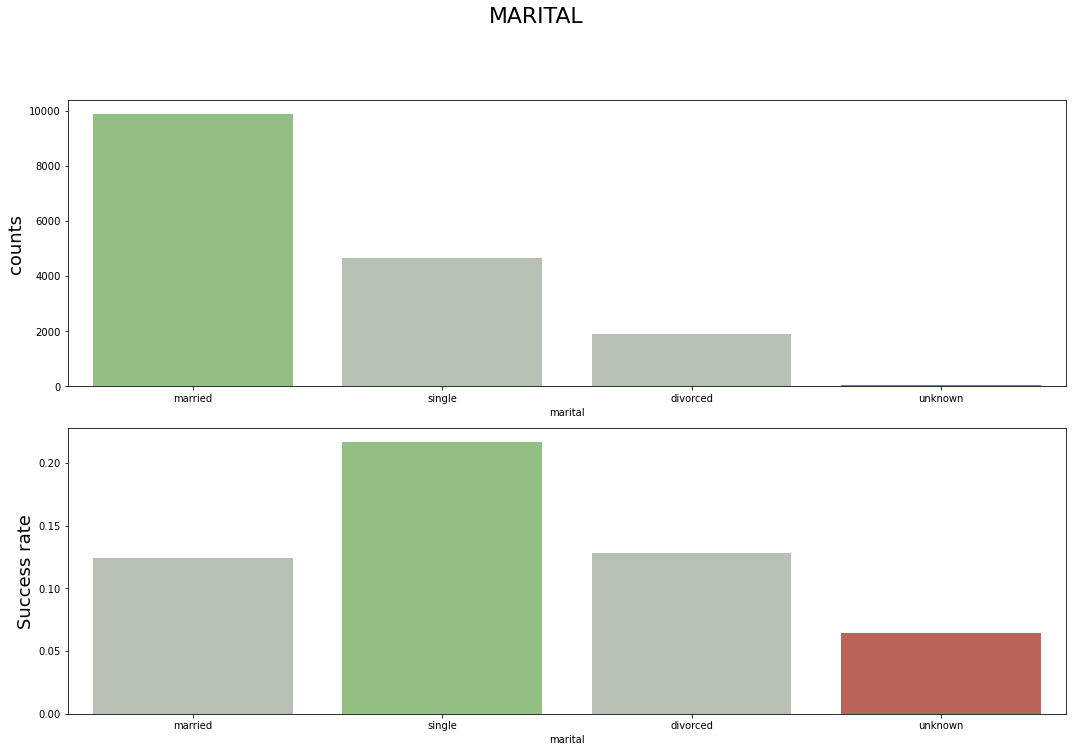

In [60]:
next(gen)

__Martial - Findings__:

- single people has the highest success rate within all groups
- Few, missing values labeled as unknown

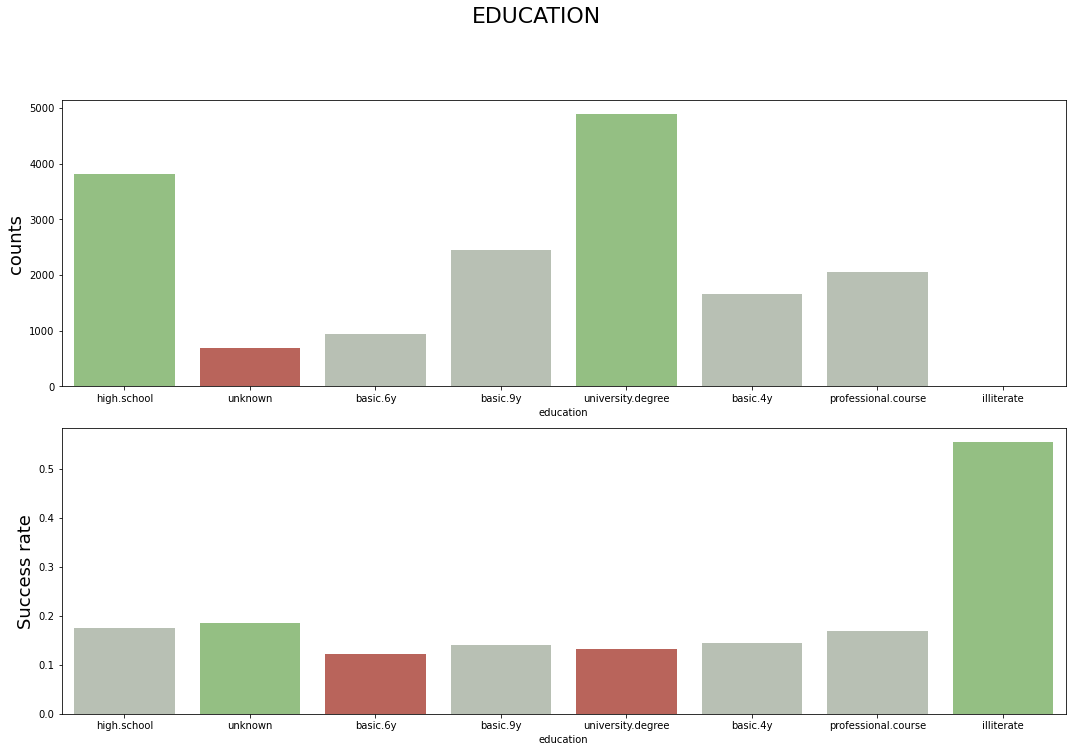

In [61]:
next(gen)

__Education - Findings__:

- Illiterate people are the best target of all education levels. 
- More then half people in the database have university degree or finished high school
- there are missing values labeled as unknown

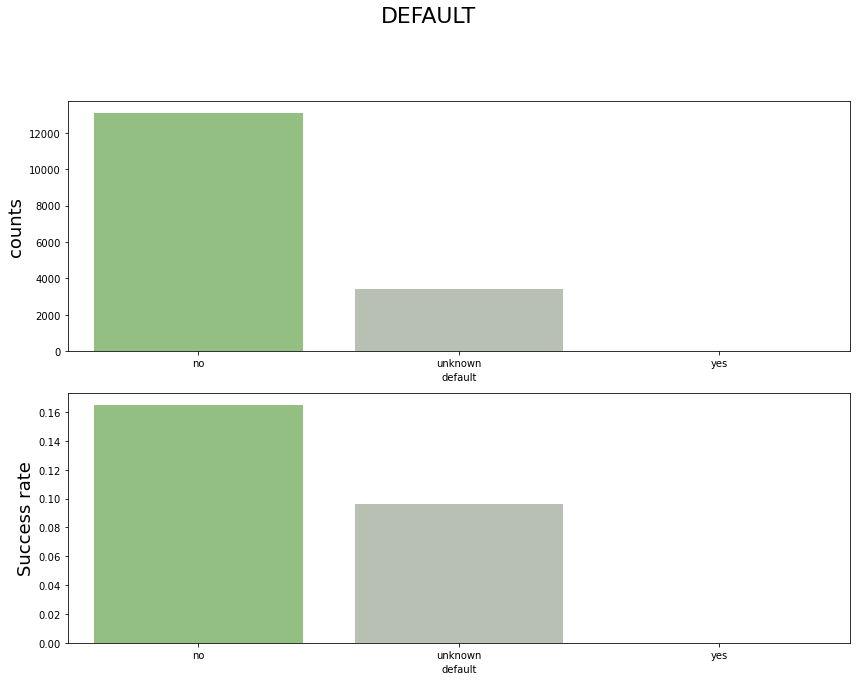

In [62]:
next(gen)

__Default - Findings__:

- There are only 3 people with Default
- Missing values labeled as unknown

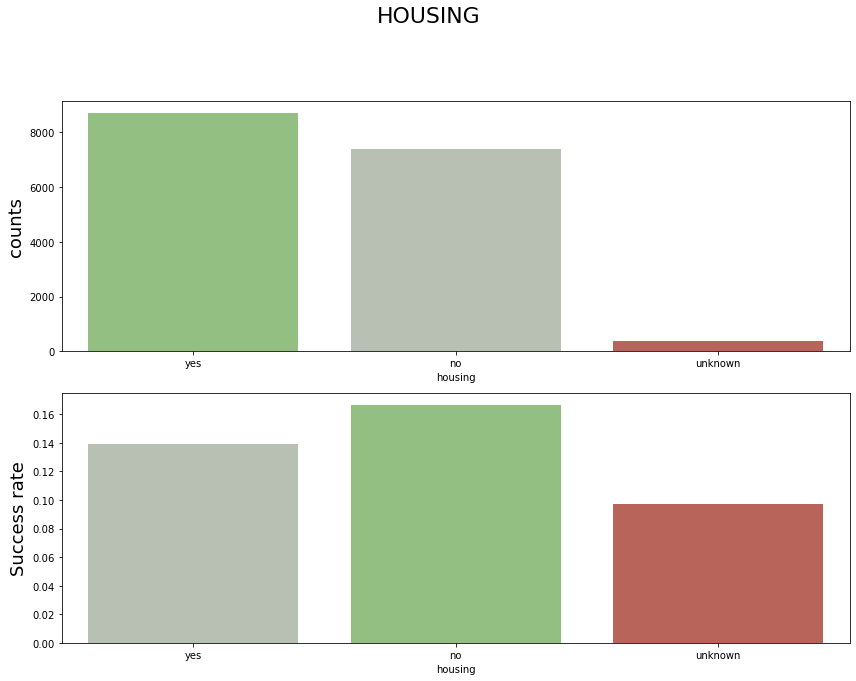

In [63]:
next(gen)

__Default - Housing__:

- There are almost no differences between success rate on housing feature categories
- There is some missing data labeled as unknown

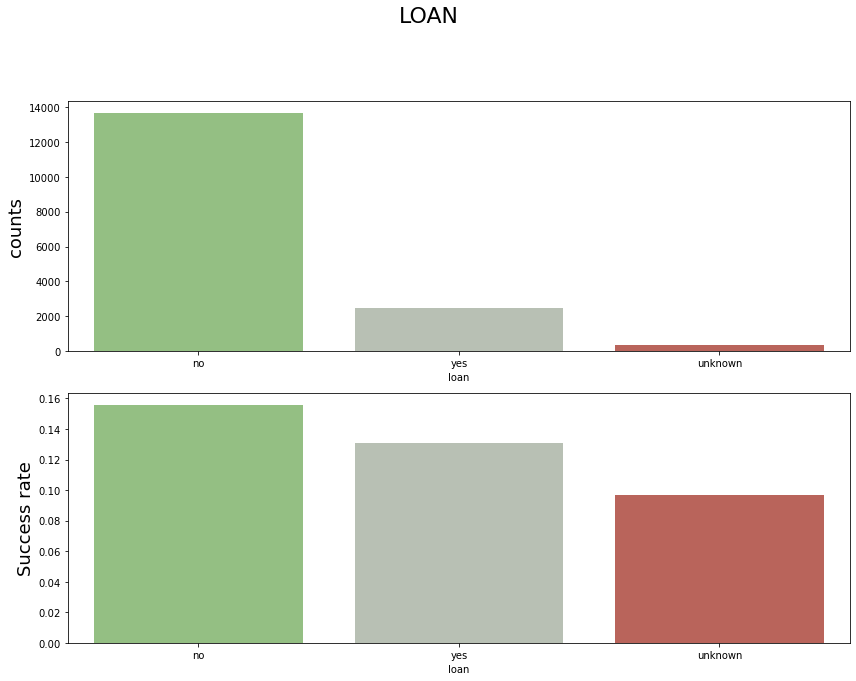

In [64]:
next(gen)

__Loan - Findings__:

- Success rate is almost equal on all three categories
- There is some missing data labeled as unknown

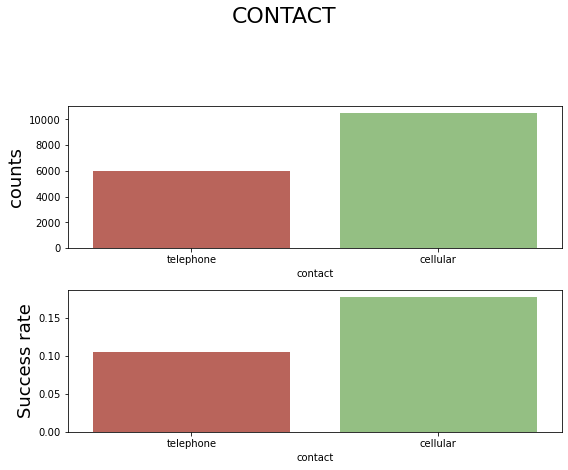

In [65]:
next(gen)

__Contact - Findings__:

- Cellular seem the better way of contact.
- This feature might be useful while planning telemarketing strategy. We should not use it in the model.

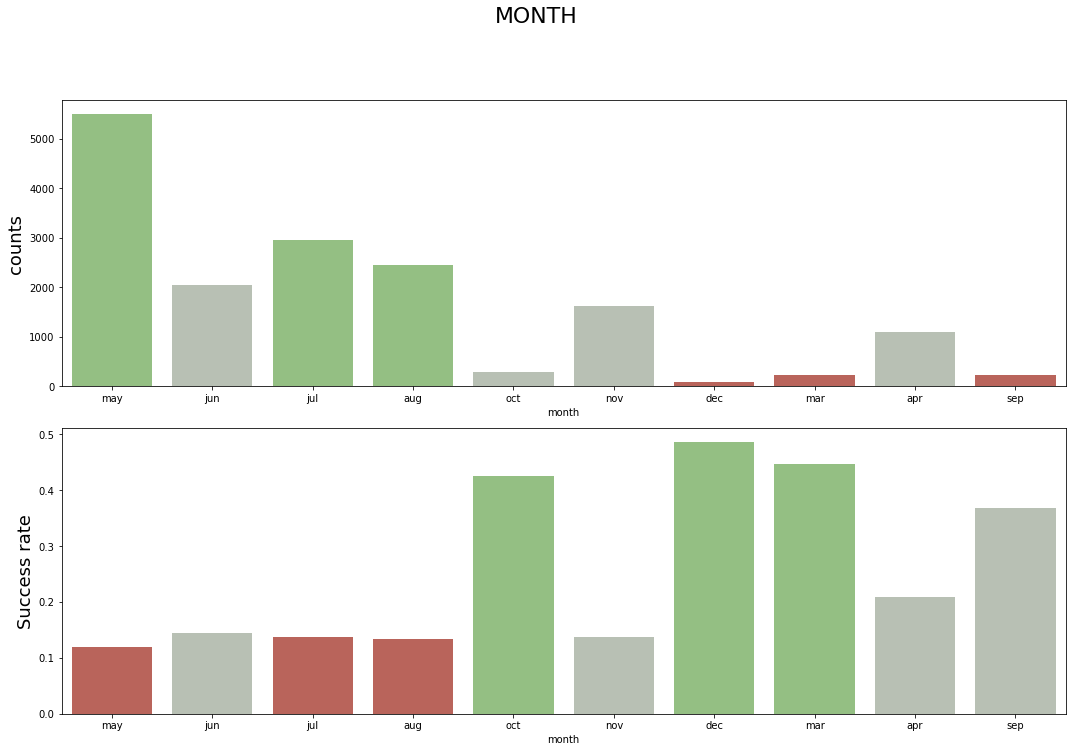

In [66]:
next(gen)

__Month - Findings__:

- October, December, and March has the highest succes rate ratio, but there almost no records from that period. 

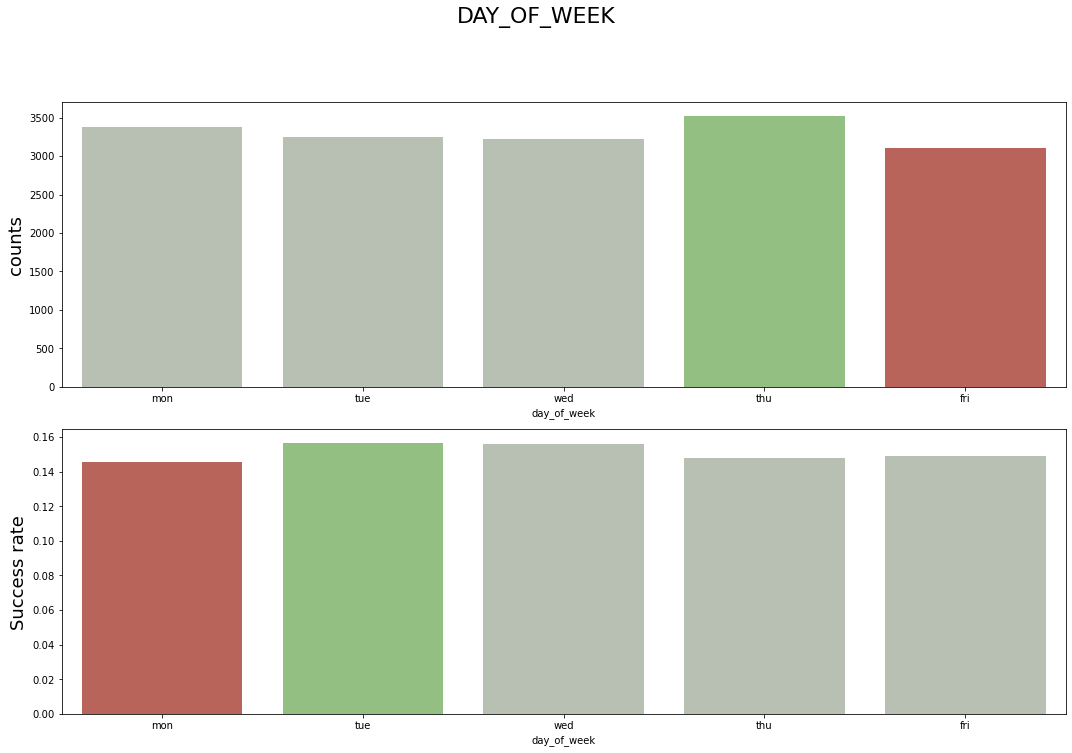

In [67]:
next(gen)

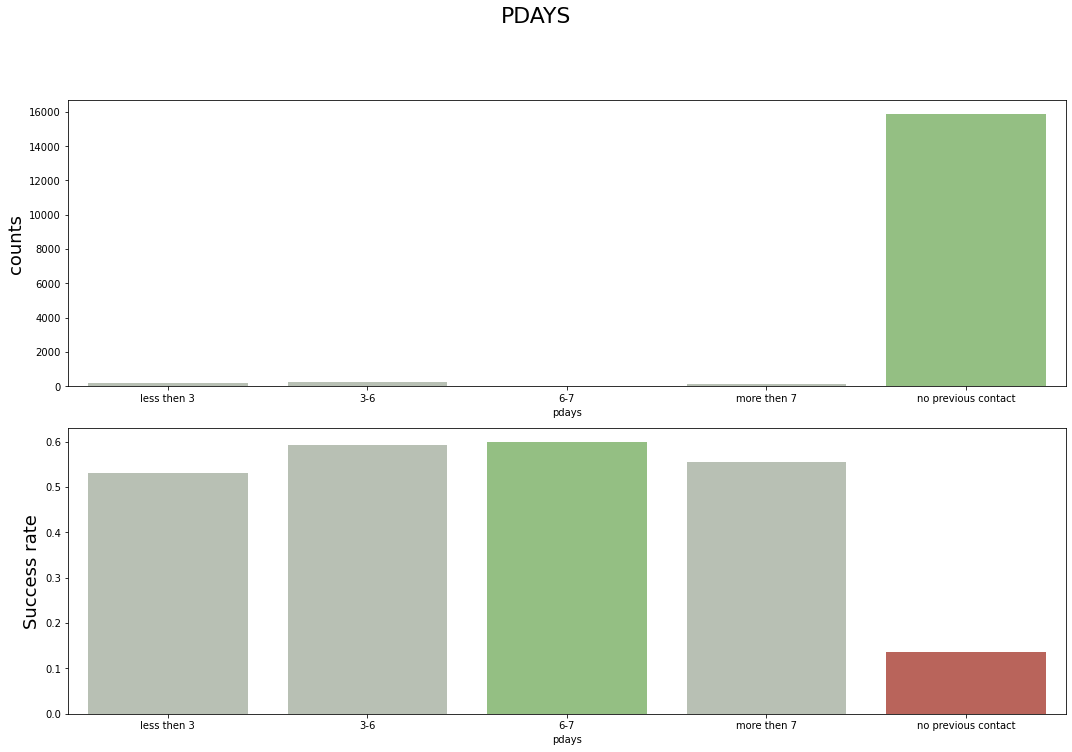

In [68]:
next(gen)

__pdays - Findings__:

Description: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

- Almost all used records contain people who were not contacted during last campaign.

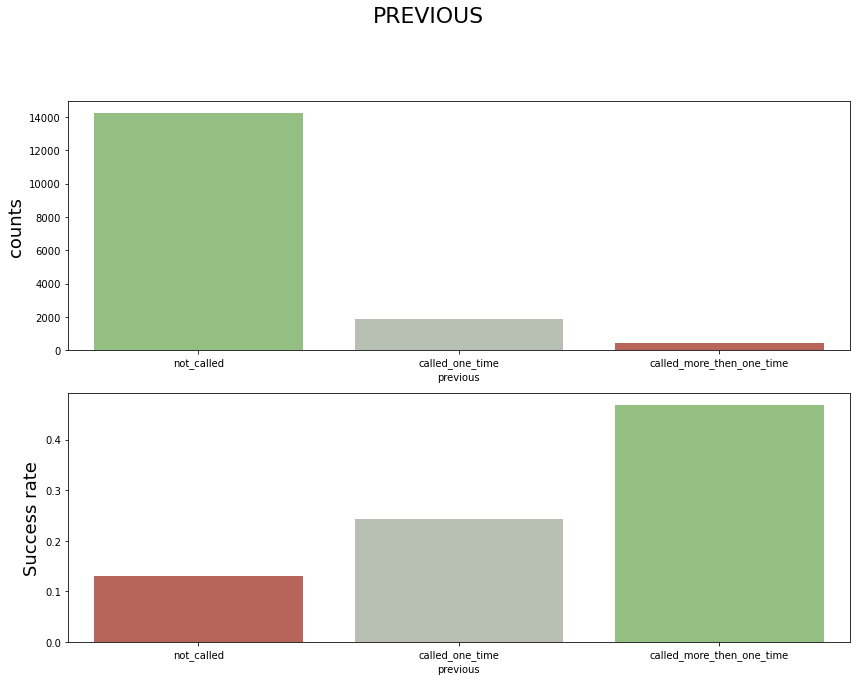

In [69]:
next(gen)

__Previous - Findings__:

Description: number of contacts performed before this campaign and for this client 

- Previous call numbers might be a good indicator of a success on next campaign. Unfortunetly most of the records is labeled here as 'not_called'

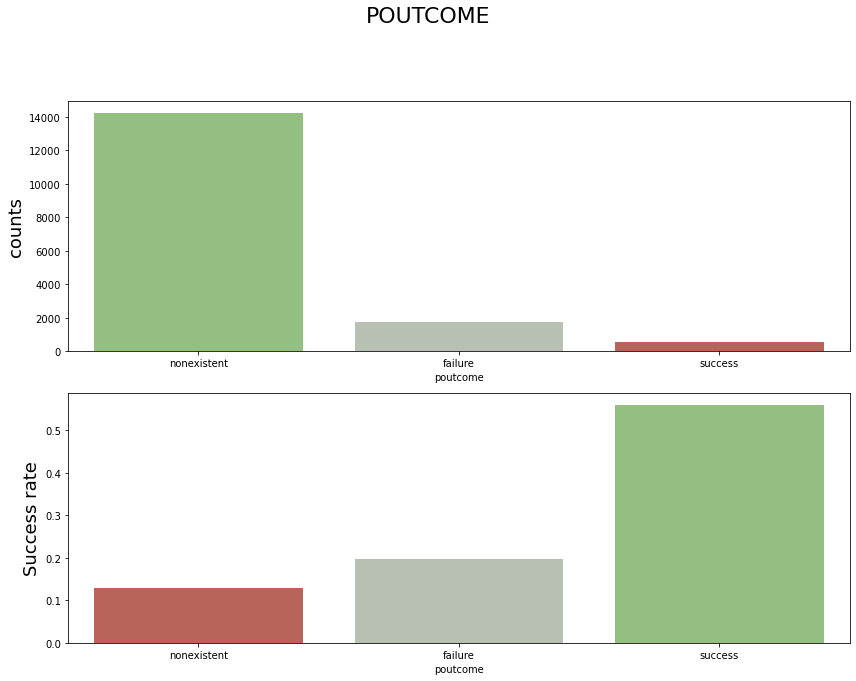

In [70]:
next(gen)

__Poutcome - Findings__:
    
Description:  outcome of the previous marketing campaign

- Previous Success is a good indicator of success in the next campaign.
- It's not strange that Previous and Poutcome has so low success rates on the nonexisting group. If you didn't call the person, it has to reach you on their own. Success means something different in this case.
- I think that model might favorite people group failure over nonexistent which might be a problem, but a low count of failures and the low difference between success rates get me thinking that predictions will fine.

In [72]:
def plot_correlation_matrix(data):
    fig = plt.figure(figsize=(10, 8)); ax = fig.add_axes()
    sns.heatmap((data * 100).applymap(int), linewidths=.5, annot=True, fmt="d", cmap='viridis')

<ipython-input-72-32ebb2baa887>:2: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  fig = plt.figure(figsize=(10, 8)); ax = fig.add_axes()


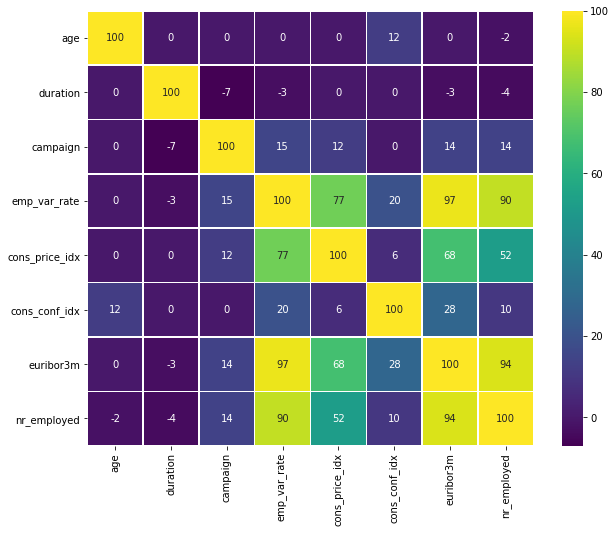

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
plot_correlation_matrix(data_to_plot.select_dtypes(['number']).corr())

Features `emp_var_rate`, `euribor3m`, and `nr_employed` and are highly correlated with each other.
EDA showed us, that all three of them should be a good predictor. To remove correlation, we will create a latent composition of all three of them using Principal Component Analysis.
It will be also done in the main modeling pipeline.

In [ ]:
correlated_features = ['euribor3m', 'emp_var_rate', 'nr_employed']

pca = PCA(3).fit_transform(data_to_plot[correlated_features])
data_to_plot[['pca1', 'pca2', 'pca3']] = pca
data_to_plot = data_to_plot.drop(columns=correlated_features)

<ipython-input-72-32ebb2baa887>:2: MatplotlibDeprecationWarning: Calling add_axes() without argument is deprecated since 3.3 and will be removed two minor releases later. You may want to use add_subplot() instead.
  fig = plt.figure(figsize=(10, 8)); ax = fig.add_axes()


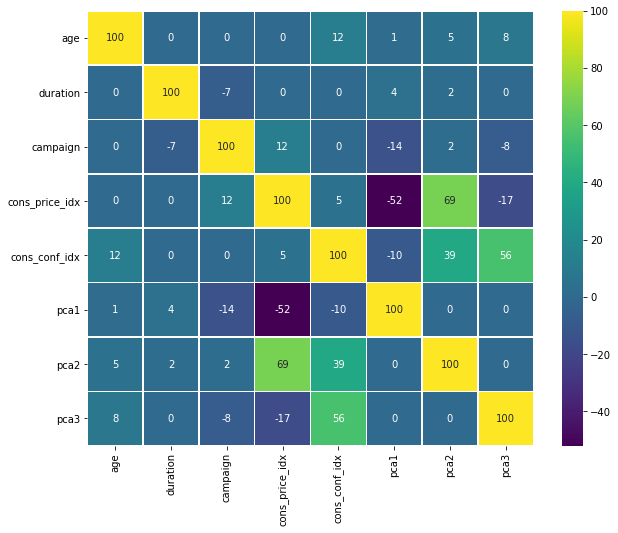

In [78]:
plot_correlation_matrix(data.select_dtypes(['number']).corr())

## Summary


This dataset is naturally splitting into two separate groups -> control group and campaign group. 
Control group contain information about natural demand for our banking services and is a good source of potential new clients in the next marketing campaign. The campaign group contains information about the result of the call which should be very informative while trying to create a predictive model.

The Control group doesn't have contact-related information, but it is not a problem because we can't use those features in further analysis. For example, it's impossible to use the duration of the call to predict if this call should ever happen. Even though those variables seem useless for the modeling phase, we might use them, and all insights that came from the EDA as bits of advice for the marketers. Features that contain such information: ['duration', campaign, "month", 'day_of_week', 'contact']


In few categorical features occurs the "Unknown" category, which indicates that it should be a missing value instead. We might OneHotEncode which simply turns all feature-categories into 0. We will do this in all cases.

There are three strongly correlated economic context attributes. I have a little problem with using them as predictors because they are not set in stone, and may change in the future. Nevertheless, I have decided to use them, but they need a PCA transforming step, because of the high correlation between them.

I have also decided to discrete two continuous variables 'pday' and 'previous', to deal with its skewness and imputation with a value '999' which will strongly influence any linear model we might decide to use. 

Those three steps (one-hot encoding, PCA, binning) will be used during the modeling phase.

Cons_price_index and cons_conf_index have a multimodal distribution which may be problematic while using linear models. If we decided to create one, we might want to consider binning it to extract each local maximum or try to tackle this differently. I assume that tree-based models will handle this data with ease and it seems a better approach in the next step.

Additionally, feature cons_price_idx have 250 missing values. Considering its unusual multimodal distribution, we should not impute it with median or mean. I think that the decision tree imputation will be a good idea to solve this problem. 

The target class is slightly unbalanced with an approximate ratio of 1:7 it is not a problem because we are focusing on the auc_roc score. Any other metric might need a step with finding optimal classification threshold or use other techniques to solve this issue (like SMOTE, Tomek-links, or upsampling).